# Assessed Exercise for Deep Learning
### Kristina Kuzeva



# Dataset source: https://www.kaggle.com/gpiosenka/100-bird-species
Link to the changed dataset in my drive: [https://drive.google.com/drive/folders/100-bird-species-NEW/](https://drive.google.com/drive/folders/1OL2zX4Vtdhu59jUz_Y-JWjzAZ0D5RdEO?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image
import pandas as pd
import time

# 1. Analysis of the problem
*What are you trying to solve, and what are the challenges in the task?*

The dataset contains pictures of 130 bird species. The implementation aims to train a neural networks to detect the species of bird from a picture of it, not considering it's angle position.

The task presents some challenges, such as that the dataset is unbalanced and some of the information given was wrong. Furthermore, the pictures are taken from different angles and sometimes the birds are partially occluded. The birds are different colours and the background varies. Sometimes pictures of the same species look like they are not the same colour. 

A possible problem could be for the network to learn the background instead of the bird features. For example the emperor penguin appears only on white and blue background.


Example of occluded image:


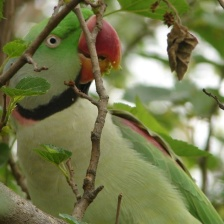


Example of different angles and backgrounds:


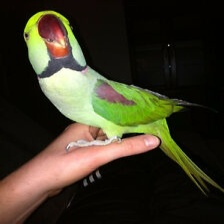

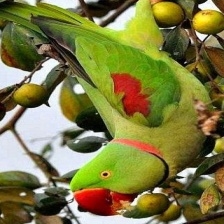


Example of different quality:


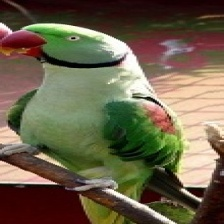

In [ ]:
print("Example of occluded image:")
pil_img = Image(filename='/content/drive/My Drive/DL/100-bird-species-NEW/train/ALEXANDRINE PARAKEET/004.jpg')
display(pil_img)
print()
print("Example of different angles and backgrounds:")
pil_img = Image(filename='/content/drive/My Drive/DL/100-bird-species-NEW/train/ALEXANDRINE PARAKEET/001.jpg')
display(pil_img)
print()
pil_img = Image(filename='/content/drive/My Drive/DL/100-bird-species-NEW/train/ALEXANDRINE PARAKEET/012.jpg')
display(pil_img)
print()
print("Example of different quality:")
pil_img = Image(filename='/content/drive/My Drive/DL/100-bird-species-NEW/train/ALEXANDRINE PARAKEET/010.jpg')
display(pil_img)

# 2. Visualisation and analysis
*Visualisation and analysis of the data type, quality and class distributions. You may want to design some data augmentation in your system.*

Information about the data:
*   There are 17038 training images, 650 test images (5 per species) and 650 validation images (5 per species).
*   All images are 224 X 224 X 3 colour images in jpg format.
*   The training set is not balanced, however each species has at least 100 training image files. 
*   After that the images were cropped so that the bird occupies at least 50% of the pixel in the image.
*   Images were gather from internet searches by species name. 
*   The name of the species is the folder the pictures are in. 
Images are also numbered sequentially with "zeros" padding. For example 001.jpg, 002.jpg ….010.jpg, 011.jpg …..099.jpg, 100jpg, 102.jpg etc.
*   The images come from different sources, so the quality varies. Finally, some images were cropped or stretched.




As mentioned in the previous task, when I was examining the data I found out that the information given in the description of the dataset was not entirely true. I found the following mistakes:
*   Some images were bigger than 224 X 224 and some were in png format. That was fixed with reshaping all images to the correct format.
*   About 30 of the 130 had less than 100 images, as the lowest number was 78. Additionally, the classes were too much and the testing was too slow. To solve both problems and increase the images for each class, all folders that had less than 155 images were removed. That left 20 classes. Furthermore, the images above 155 were removed from their respected folders to balance the dataset.
*   Not all images had zero padding and the paddings were inconsistent. That was not a problem for the training.

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

train_set = ImageFolder('/content/drive/My Drive/DL/100-bird-species-NEW/train/', transform)
test_set = ImageFolder('/content/drive/My Drive/DL/100-bird-species-NEW/test/', transform)
validation_set = ImageFolder('/content/drive/My Drive/DL/100-bird-species-NEW/valid/', transform)

In [ ]:
torch.manual_seed(42)
np.random.seed(5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = list(train_set.class_to_idx.keys())
epochs, batch, classes_number = 30, 64, len(classes)
print(classes_number)
print(classes, end = ", ")

20
['ALEXANDRINE PARAKEET', 'AMERICAN BITTERN', 'BALD EAGLE', 'BOBOLINK', 'COCKATOO', 'DARK EYED JUNCO', 'FLAME TANAGER', 'GLOSSY IBIS', 'GRAY CATBIRD', 'HOUSE FINCH', 'MARABOU STORK', 'PAINTED BUNTIG', 'PARADISE TANAGER', 'PEACOCK', 'STRAWBERRY FINCH', 'TURQUOISE MOTMOT', 'VARIED THRUSH', 'VERMILION FLYCATHER', 'WOOD DUCK', 'YELLOW HEADED BLACKBIRD'], 

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch, shuffle = True, num_workers = 2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = batch, shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch, shuffle = True, num_workers = 2)

ALEXANDRINE PARAKEET


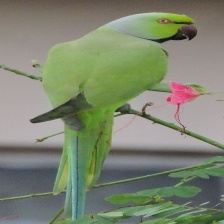


AMERICAN BITTERN


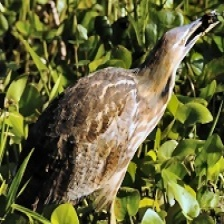


BALD EAGLE


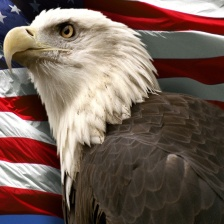


BOBOLINK


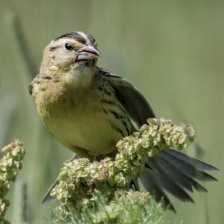


COCKATOO


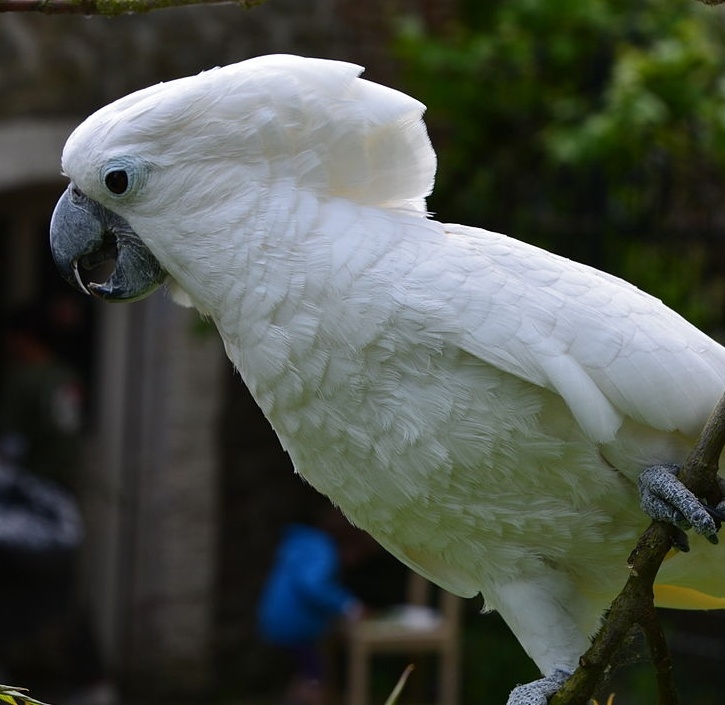


DARK EYED JUNCO


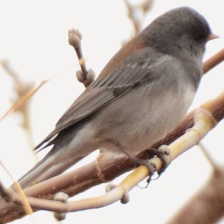


FLAME TANAGER


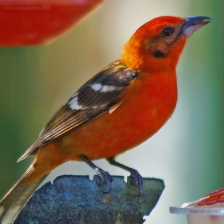


GLOSSY IBIS


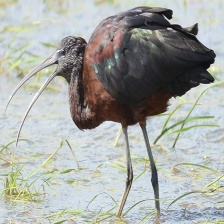


GRAY CATBIRD


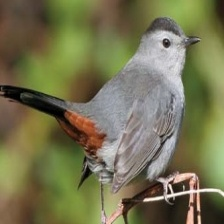


HOUSE FINCH


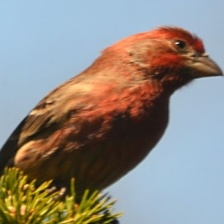


MARABOU STORK


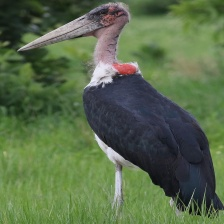


PAINTED BUNTIG


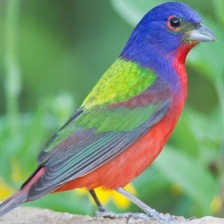


PARADISE TANAGER


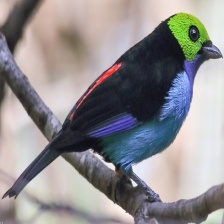


PEACOCK


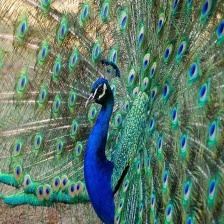


STRAWBERRY FINCH


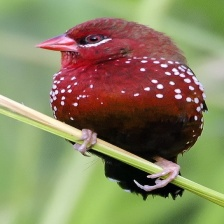


TURQUOISE MOTMOT


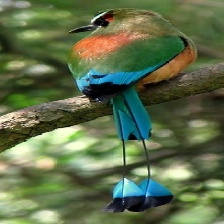


VARIED THRUSH


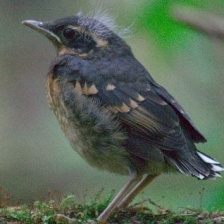


VERMILION FLYCATHER


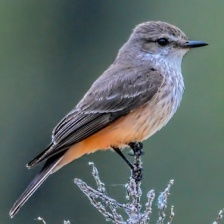


WOOD DUCK


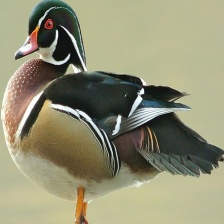


YELLOW HEADED BLACKBIRD


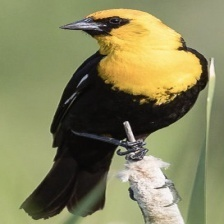

In [ ]:
#Example of images from each class
pictures_in_class = int(len(train_set)/classes_number)
for i in range(classes_number):
  print(classes[i])
  pil_img = Image(filename=train_set.imgs[(i*pictures_in_class)+7][0])
  display(pil_img)
  print()


 # 3. Creation of multiple candidate network architectures
*Include your justification of the design decisions. You should inlcude one very simple baseline model (e.g. a linear model, or a simple two layer Densely connected model).*

I choose to implement a dense layer model (baseline), a simple convnet and a pretrained alexnet. The idea behind the choice of networks is that every next one is more complex and has more layers. Other factors, such as the optimiser and the loss function were kept intentionally the same.

### Dense Layer Model 

In [ ]:
class Dense(nn.Module):
    def __init__(self):
        super(Dense, self).__init__()
        self.fc1 = nn.Linear(3*224*224, 125*4)
        self.fc1_drop = nn.Dropout2d(p = 0.4)
        self.fc2 = nn.Linear(125*4, classes_number)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

Dense()

Dense(
  (fc1): Linear(in_features=150528, out_features=500, bias=True)
  (fc1_drop): Dropout2d(p=0.4, inplace=False)
  (fc2): Linear(in_features=500, out_features=20, bias=True)
)

### Simple ConvNet

In [ ]:
class Convolutional(nn.Module):
    def __init__(self):
        super(Convolutional, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
        self.fc1 = nn.Linear(128*4*4, 125*4)
        self.fc1_drop = nn.Dropout(p = 0.4)
        self.fc2 = nn.Linear(125*4, 16*16)
        self.fc2_drop = nn.Dropout(p = 0.4)
        self.fc3 = nn.Linear(16*16, classes_number)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        


    def forward(self, x):
        x = F.leaky_relu(self.pool(self.conv1_bn(self.conv1(x))))
        x = F.leaky_relu(self.pool(self.conv2_bn(self.conv2(x))))
        x = F.leaky_relu(self.pool(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

Convolutional()

Convolutional(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc2_drop): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=20, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### Pretrained AlexNet

In [ ]:
alexnet = models.alexnet(pretrained = True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# 4. Training
*This should include code for hyperparameter search, regularisation methods.*

For the training, Adam was used as an optimiser with all of the neural networks. To compute the gradient according to a given loss function was used CrossEntropyLoss. For the hyperparameter search, the networks were trained with 2 different learning rates - 0.01 and 0.001. 

In [ ]:
def run_model(model, optimizer, criterion):
  current = time.time()

  model = model.cuda()
  train_accuracy = []
  train_loss = []
  validation_accuracy = []
  validation_loss = []

  for e in range(epochs):
    if e<10: s = "Epoch number 0" + str(e) + ":"
    else: s = "Epoch number " + str(e) + ":"
    print(s, end = ": ")

    model.train()

    train_accuracy_number = 0
    train_loss_number = 0
    for i,(pics, labels) in enumerate(train_loader):
      pics, labels = pics.cuda(), labels.cuda()
      optimizer.zero_grad()
      train_out = model(pics)
      loss = criterion(train_out, labels)
      loss.backward()
      train_loss_number += loss.item()
      optimizer.step()
      prediction = train_out.max(1, keepdim = True)[1]
      train_accuracy_number += prediction.eq(labels.view_as(prediction)).sum().item()

    train_loss_number /= len(train_loader)
    acc = 100.0 * train_accuracy_number / len(np.arange(len(train_set.targets)))
    s = "Train accuracy:"+str(round(acc, 1))+"% | Train loss:"+str(round(train_loss_number, 4))
    print(s, end = " || ")
    train_loss.append(train_loss_number)
    train_accuracy.append(acc)

    model.eval()
    validation_accuracy_number = 0
    validation_loss_number = 0
    with torch.no_grad():
      for i,(pics, labels) in enumerate(validation_loader):
        pics, labels = pics.cuda(), labels.cuda()
        validation_out = model(pics)
        loss = criterion(validation_out, labels)
        validation_loss_number += loss.item()
        prediction = validation_out.max(1, keepdim = True)[1]
        validation_accuracy_number += prediction.eq(labels.view_as(prediction)).sum().item()
    validation_loss_number /= len(validation_loader)
    acc = 100.0 * validation_accuracy_number / len(np.arange(len(validation_set.targets)))
    s = "Validation accuracy:"+str(round(acc, 1))+"% | Validation loss:"+str(round(validation_loss_number,4))
    print(s)
    validation_loss.append(validation_loss_number)
    validation_accuracy.append(acc)


  end = time.time()
  diff = end - current
  print("Training took %d seconds" % (diff))
  print("Best loss for:", end=": ")
  s = "training: "+str(round(min(train_loss), 2))+" | validation: "+str(round(min(validation_loss), 2))
  print(s)
  print("Best accuracy for:", end=": ")
  s = "training: "+str(round(max(train_accuracy), 2))+" | validation: "+str(round(max(validation_accuracy), 2))
  print(s)

  plot_model(train_loss, validation_loss, epochs, "Loss")
  plot_model(train_accuracy, validation_accuracy, epochs, "Accuracy")
  
  return model

In [ ]:
def test_model(model, criterion):
  model.eval()
  test_loss = 0
  test_accuracy = 0
  class_accuracy = list(0 for i in range(classes_number))
  class_num = list(0 for i in range(classes_number))
  predictions = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labels_ = torch.zeros(0, dtype = torch.long, device = 'cpu')

  with torch.no_grad():
    wrong_classification = torch.Tensor([])
    for i,(pics, labels) in enumerate(test_loader):
      pics, labels = pics.cuda(), labels.cuda()
      test_out = model(pics)
      loss = criterion(test_out, labels)
      test_loss += loss.item()
      _, prediction = torch.max(test_out.data, 1)
      test_accuracy += (prediction == labels).sum().item()
      pred = (prediction == labels).squeeze()
      predictions = torch.cat([predictions, prediction.view(-1).cpu()])
      labels_ = torch.cat([labels_, labels.view(-1).cpu()])
      
      for j in range(labels.size(0)):
        l = labels[j]
        class_accuracy[l] += pred[j].item()
        class_num[l] += 1

  test_loss /= len(test_loader)
  acc = 100.0 * test_accuracy / len(test_loader.dataset)
  print("For test: ", end = ": ")
  s = "accuracy: "+str(round(acc, 2))+" | loss: "+str(round(test_loss, 2))
  print(s)
  print("Class Accuracies: ", end = ": ")
  for k in range(classes_number):
      print((100.0 * class_accuracy[k]/class_num[k]), end = "%, ")

In [ ]:
def plot_model(train_loss, validation_loss, epochs, type_):
  plt.figure(figsize=(8, 6))
  plt.plot(range(epochs), train_loss, color='c', label="Training"+type_)
  plt.plot(range(epochs), validation_loss, color='m', label="Validation "+type_)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(type_)

# 5. Empirical evaluation of performance
*Empirical evaluation of performance, and potentially visualisation and analysis of the trained network. This should make good use of graphs and tables of results, confusion matrices etc to represent the relative performance of the different models. Explain why you chose the metrics you use.*

In the output for each model, the empirical information can be seen. 
For each model, there are two graphs, showing the learning rate and loss for every epoch, both for the training and validation data. Additionally, there is information about the accuracy of every class. 
For each epoch, the accuracy and loss for the validation and training is printed out and at the end, there is some information about the overall performance of the model (for example the training accuracy and loss).

### Dense Layer Model 

Epoch number 00:: Train accuracy:6.7% | Train loss:188.4793 || Validation accuracy:9.0% | Validation loss:32.4011
Epoch number 01:: Train accuracy:7.7% | Train loss:48.6739 || Validation accuracy:9.0% | Validation loss:34.3273
Epoch number 02:: Train accuracy:8.0% | Train loss:48.1777 || Validation accuracy:9.0% | Validation loss:32.2145
Epoch number 03:: Train accuracy:10.7% | Train loss:43.5942 || Validation accuracy:20.0% | Validation loss:27.5657
Epoch number 04:: Train accuracy:10.8% | Train loss:55.3877 || Validation accuracy:16.0% | Validation loss:49.134
Epoch number 05:: Train accuracy:10.1% | Train loss:76.0877 || Validation accuracy:6.0% | Validation loss:123.6574
Epoch number 06:: Train accuracy:9.3% | Train loss:82.343 || Validation accuracy:14.0% | Validation loss:58.1744
Epoch number 07:: Train accuracy:10.1% | Train loss:66.038 || Validation accuracy:16.0% | Validation loss:55.0987
Epoch number 08:: Train accuracy:10.3% | Train loss:71.9193 || Validation accuracy:16.0% 

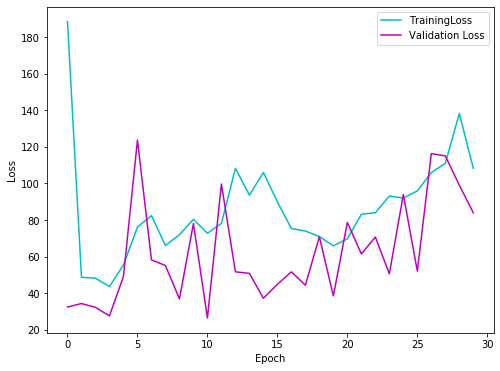

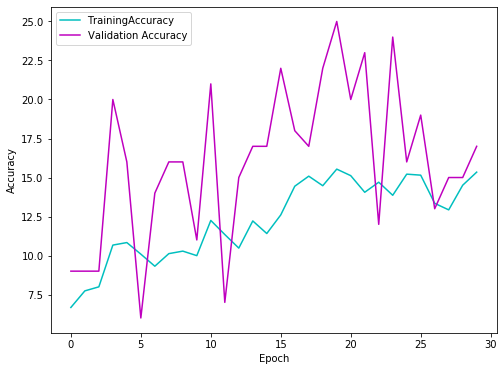

In [ ]:
dense01 = Dense().cuda()
optimizer = optim.Adam(dense01.parameters(), lr = 0.01)
dense01 = run_model(dense01, optimizer, nn.CrossEntropyLoss())
test_model(dense01, nn.CrossEntropyLoss())

Epoch number 00:: Train accuracy:7.4% | Train loss:18.1076 || Validation accuracy:16.0% | Validation loss:2.9354
Epoch number 01:: Train accuracy:9.3% | Train loss:3.4767 || Validation accuracy:18.0% | Validation loss:2.6996
Epoch number 02:: Train accuracy:11.4% | Train loss:3.4271 || Validation accuracy:19.0% | Validation loss:2.8956
Epoch number 03:: Train accuracy:11.9% | Train loss:3.3017 || Validation accuracy:19.0% | Validation loss:2.5991
Epoch number 04:: Train accuracy:12.8% | Train loss:3.1492 || Validation accuracy:25.0% | Validation loss:2.5179
Epoch number 05:: Train accuracy:13.9% | Train loss:3.1332 || Validation accuracy:19.0% | Validation loss:3.055
Epoch number 06:: Train accuracy:14.9% | Train loss:3.2684 || Validation accuracy:24.0% | Validation loss:2.6261
Epoch number 07:: Train accuracy:16.1% | Train loss:3.0983 || Validation accuracy:33.0% | Validation loss:2.3113
Epoch number 08:: Train accuracy:15.7% | Train loss:3.1217 || Validation accuracy:24.0% | Validati

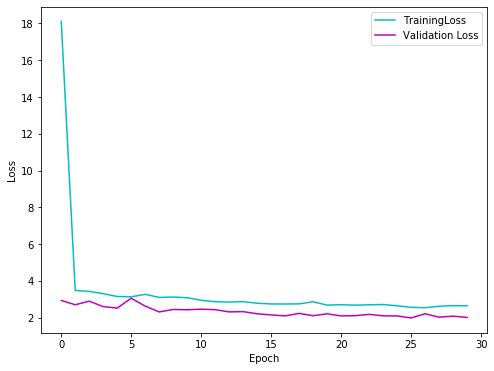

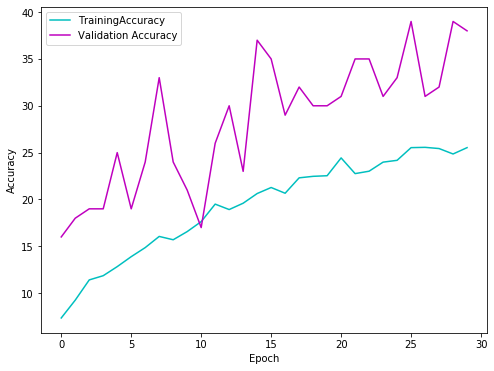

In [ ]:
dense001 = Dense().cuda()
optimizer = optim.Adam(dense001.parameters(), lr = 0.001)
dense001 = run_model(dense001, optimizer, nn.CrossEntropyLoss())
test_model(dense001, nn.CrossEntropyLoss())

### Simple ConvNet

Epoch number 00:: Train accuracy:10.3% | Train loss:3.0334 || Validation accuracy:19.0% | Validation loss:2.5462
Epoch number 01:: Train accuracy:20.7% | Train loss:2.5242 || Validation accuracy:23.0% | Validation loss:2.2471
Epoch number 02:: Train accuracy:24.0% | Train loss:2.3914 || Validation accuracy:34.0% | Validation loss:2.1106
Epoch number 03:: Train accuracy:31.1% | Train loss:2.2116 || Validation accuracy:43.0% | Validation loss:1.706
Epoch number 04:: Train accuracy:38.0% | Train loss:2.0252 || Validation accuracy:52.0% | Validation loss:1.534
Epoch number 05:: Train accuracy:43.5% | Train loss:1.8688 || Validation accuracy:56.0% | Validation loss:1.4455
Epoch number 06:: Train accuracy:45.9% | Train loss:1.7856 || Validation accuracy:61.0% | Validation loss:1.285
Epoch number 07:: Train accuracy:50.0% | Train loss:1.6631 || Validation accuracy:51.0% | Validation loss:1.4197
Epoch number 08:: Train accuracy:52.1% | Train loss:1.5962 || Validation accuracy:56.0% | Validatio

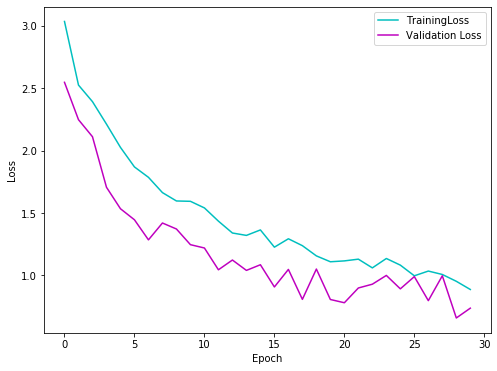

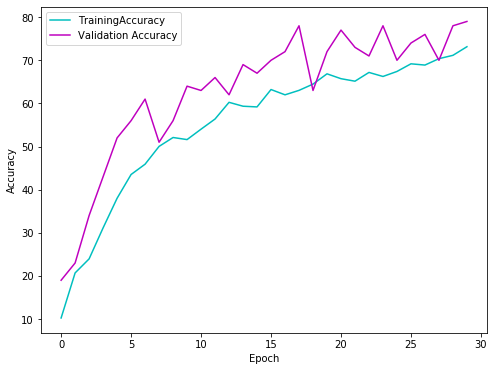

In [ ]:
cnn01 = Convolutional().cuda()
optimizer = optim.Adam(cnn01.parameters(), lr = 0.01)
cnn01 = run_model(cnn01, optimizer, nn.CrossEntropyLoss())
test_model(cnn01, nn.CrossEntropyLoss())

Epoch number 00:: Train accuracy:17.6% | Train loss:2.6249 || Validation accuracy:41.0% | Validation loss:1.9141
Epoch number 01:: Train accuracy:43.5% | Train loss:1.8083 || Validation accuracy:62.0% | Validation loss:1.2206
Epoch number 02:: Train accuracy:55.6% | Train loss:1.379 || Validation accuracy:77.0% | Validation loss:0.8395
Epoch number 03:: Train accuracy:64.3% | Train loss:1.1406 || Validation accuracy:77.0% | Validation loss:0.7307
Epoch number 04:: Train accuracy:69.9% | Train loss:0.9501 || Validation accuracy:83.0% | Validation loss:0.4942
Epoch number 05:: Train accuracy:74.5% | Train loss:0.8071 || Validation accuracy:87.0% | Validation loss:0.4272
Epoch number 06:: Train accuracy:77.7% | Train loss:0.7476 || Validation accuracy:87.0% | Validation loss:0.4076
Epoch number 07:: Train accuracy:81.2% | Train loss:0.6034 || Validation accuracy:89.0% | Validation loss:0.4234
Epoch number 08:: Train accuracy:81.7% | Train loss:0.5773 || Validation accuracy:87.0% | Validat

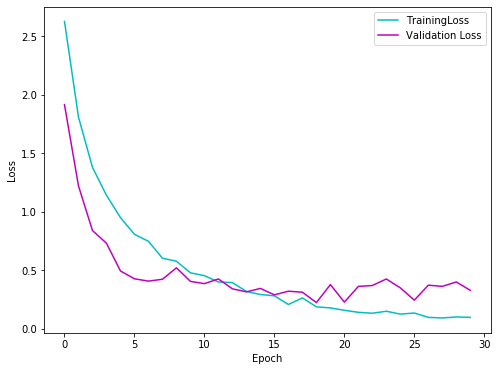

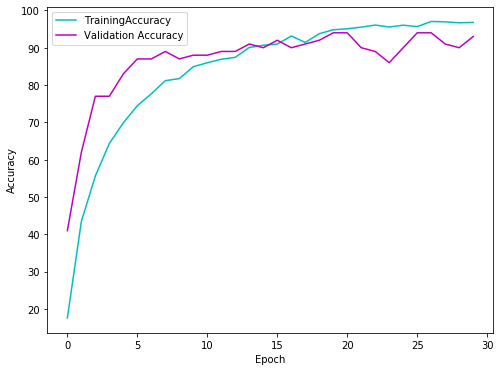

In [ ]:
cnn001 = Convolutional().cuda()
optimizer = optim.Adam(cnn001.parameters(), lr = 0.001)
cnn001 = run_model(cnn001, optimizer, nn.CrossEntropyLoss())
test_model(cnn001, nn.CrossEntropyLoss())

### Pretrained AlexNet

Epoch number 00:: Train accuracy:66.9% | Train loss:2.6212 || Validation accuracy:94.0% | Validation loss:0.5306
Epoch number 01:: Train accuracy:83.0% | Train loss:1.0424 || Validation accuracy:94.0% | Validation loss:0.4761
Epoch number 02:: Train accuracy:86.9% | Train loss:0.8835 || Validation accuracy:94.0% | Validation loss:0.4938
Epoch number 03:: Train accuracy:86.3% | Train loss:0.9136 || Validation accuracy:87.0% | Validation loss:1.335
Epoch number 04:: Train accuracy:88.6% | Train loss:0.8662 || Validation accuracy:88.0% | Validation loss:0.9159
Epoch number 05:: Train accuracy:88.8% | Train loss:0.7957 || Validation accuracy:95.0% | Validation loss:0.5706
Epoch number 06:: Train accuracy:90.4% | Train loss:0.639 || Validation accuracy:93.0% | Validation loss:0.5918
Epoch number 07:: Train accuracy:90.1% | Train loss:0.7485 || Validation accuracy:88.0% | Validation loss:0.7345
Epoch number 08:: Train accuracy:90.9% | Train loss:0.6535 || Validation accuracy:94.0% | Validati

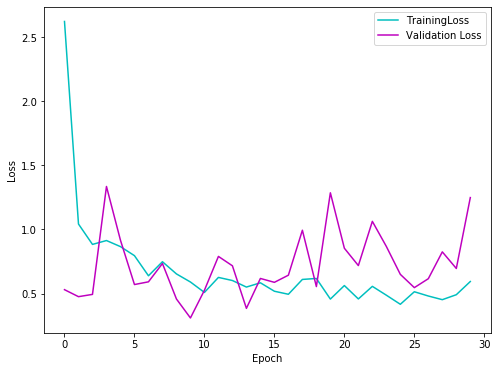

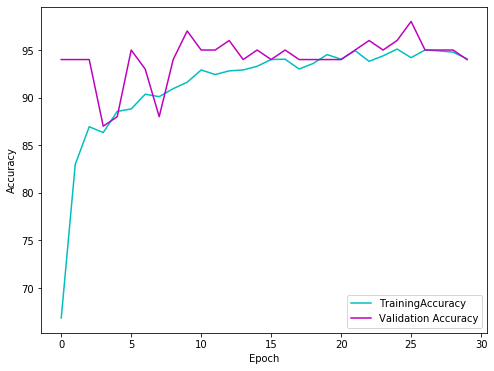

In [ ]:
alexnet01 = models.alexnet(pretrained = True)
for parameter in alexnet01.parameters():
    parameter.requires_grad = False
num_ftrs = alexnet01.classifier[6].in_features
alexnet01.classifier[6] = nn.Linear(num_ftrs, classes_number)
optimizer = optim.Adam(alexnet01.parameters(), lr = 0.01)
alexnet01 = run_model(alexnet01, optimizer, nn.CrossEntropyLoss())
name = "alexnet01_adam.pth"
path = F"/content/drive/My Drive/DL/alexnet/{name}"
torch.save(alexnet01.state_dict(), path)
test_model(alexnet01, nn.CrossEntropyLoss())

Epoch number 00:: Train accuracy:69.1% | Train loss:1.0359 || Validation accuracy:92.0% | Validation loss:0.2709
Epoch number 01:: Train accuracy:87.6% | Train loss:0.4271 || Validation accuracy:94.0% | Validation loss:0.2326
Epoch number 02:: Train accuracy:89.2% | Train loss:0.3422 || Validation accuracy:94.0% | Validation loss:0.2111
Epoch number 03:: Train accuracy:91.8% | Train loss:0.2743 || Validation accuracy:96.0% | Validation loss:0.2324
Epoch number 04:: Train accuracy:92.8% | Train loss:0.241 || Validation accuracy:95.0% | Validation loss:0.217
Epoch number 05:: Train accuracy:94.2% | Train loss:0.2001 || Validation accuracy:95.0% | Validation loss:0.1987
Epoch number 06:: Train accuracy:94.1% | Train loss:0.1943 || Validation accuracy:93.0% | Validation loss:0.1723
Epoch number 07:: Train accuracy:94.1% | Train loss:0.1819 || Validation accuracy:97.0% | Validation loss:0.1478
Epoch number 08:: Train accuracy:95.1% | Train loss:0.164 || Validation accuracy:98.0% | Validatio

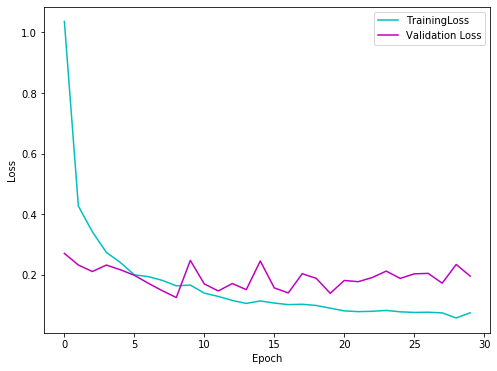

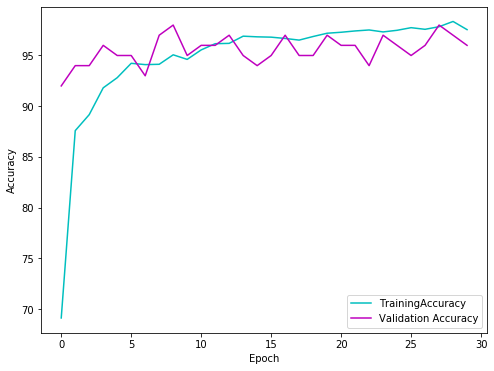

In [ ]:
alexnet001 = models.alexnet(pretrained = True)
for parameter in alexnet001.parameters():
    parameter.requires_grad = False
num_ftrs = alexnet001.classifier[6].in_features
alexnet001.classifier[6] = nn.Linear(num_ftrs, classes_number)
optimizer = optim.Adam(alexnet001.parameters(), lr = 0.001)
alexnet001 = run_model(alexnet001, optimizer, nn.CrossEntropyLoss())
name = "alexnet001_adam.pth"
path = F"/content/drive/My Drive/DL/alexnet/{name}"
torch.save(alexnet001.state_dict(), path)
test_model(alexnet001, nn.CrossEntropyLoss())

# 6. Report on the performance
*Report on the performance, discussing the suitability of the final network for use.*



## **Simple models**
###*Dense model for 0.01 learning rate*
The model is performing poorly, doing no better than chance. Also, most of the classes accuracy is 0%. Furthermore, from the graph, it can be seen that the learning is quite shaky, going back and forwards.

###*Dense model for 0.001 learning rate*
The model is the same as the previous one but the learning rate is smaller. The model is doing sufficiently better than before (more than double improvement on the test accuracy), showcasing that too big learning rate can drastically impact the performance. Additionally, there are very few classes with 0% accuracy and a lot with 60% or more.

###*Convolutional model for 0.01 learning rate*
This model has convolutional layers, apart from the linear ones. The performance is again noticeably better than the previous best. This showcases that adding convolutional layers improves learning.
The test accuracy is 78%. That is 18% more than the best linnear model.

###*Convolutional model for 0.001 learning rate*
This model is the same as the previous one, apart from the learning rate. We can see that the performance has increased drastically again. The test accuracy is 90%. That is 12% more than the previous one, solely from redusing the learning rate. Additinally, the class accuracies are now mainly 80 or more, having only one at 40% and one at 60%. In contrast, in the previous model, the lowest one was 20% and a lot were around 60%. Additionally, from the graph we can see that the the learning seem to be quite smooth.


## **Pretrained model**
For this model a pretrained AlexNet is used. The layers until the last one are frozen and it is changed, so that it can work with the number of classes we have.

###*AlexNet for 0.01 learning rate*
The pretrained model is the best model so far. This showcases that adding more layers that do different things is beneficial for the training of the model. The test accuracy is 93% and the classes are all over 80%, apart from one that is 60%.

###*AlexNet for 0.001 learning rate*
This is the last case and the best model, therefore it is the one that is recommended. The test accuracy is 97%, which is enough to be called state-of-the-art. Finally, most of the classes are at 100% accuracy, apart from three that are at 80%.

##**Conclusion**
From the experiments, it is evident that choosing correct learning rate is crusial when using neural networks. However, in order to achieve state-of-the-art performance, it is required to add depth and layers that do different things.



# Code to remove extra folders and images

In [ ]:
# # code to remove extra pictures
# import os, shutil
# path = '/content/drive/My Drive/DL/100-bird-species-NEW/train/'
# n = 155
# for r, d, f in os.walk(path):
#   if(len(f)!=0):
#     if(len(f)<n):
#       shutil.rmtree(r)
#   if((len(f)>n)):
#     print(r)
#     for file in f:
#       if(len(file)>8):
#         file_loc = r+"/"+file
#         os.remove(file_loc)
#       elif((int(file[:-4])) > n):
#         file_loc = r+"/"+file
#         os.remove(file_loc)
#     if(r=='/content/drive/My Drive/DL/100-bird-species-NEW/train/CAPE MAY WARBLER'):
#       for file in f:
#         if(len(file)<=5):
#           file_loc = r+"/"+file
#           os.remove(file_loc)

# l = []
# for r, d, f in os.walk(path):
#   if(len(f)!=0):
#     if(len(f)==n):
#       l.append(l)
#     else: print('error')
# print(len(l))

In [ ]:
# path = '/content/drive/My Drive/DL/100-bird-species-NEW/train/'
# train_d = []
# for r, d, f in os.walk(path):
#   train_d = d
#   break

# path = '/content/drive/My Drive/DL/100-bird-species-NEW/test/'
# test_d = []
# for r, d, f in os.walk(path):
#   test_d = d
#   break

# path = '/content/drive/My Drive/DL/100-bird-species-NEW/valid/'
# valid_d = []
# for r, d, f in os.walk(path):
#   valid_d = d
#   break

# for i in range(len(test_d)):
#   if(test_d[i] not in train_d):
#     r='/content/drive/My Drive/DL/100-bird-species-NEW/test/'+test_d[i]
#     shutil.rmtree(r)
#   if(valid_d[i] not in train_d):
#     r='/content/drive/My Drive/DL/100-bird-species-NEW/valid/'+valid_d[i]
#     shutil.rmtree(r)


# len(test_d)